# ETF穿越120日均线

* **买入：**收盘价上穿120日均线
* **卖出：**收盘价下穿120日均线

---

* 测试时间段：`2012-05-28~2019-12-31`
* 测试产品：`510300`
* 测试结果：
    * 25%的可能所有交易均为失败交易。失败交易平均失败3次；策略年化收益为-0.0355，基准年化收益为0.1818;
    * 75%的交易包含成功交易。失败交易平均次数为7.6912，成功交易平均次数为4.4012。策略年化收益为0.1165，基准年化收益为0.1038；
    * 总体策略年化收益为0.0793，基准年化收益为0.1229；
    
所以看上去此策略并不比买入持有好。

**Q：**问题是何时是合适的买入并持有时机？

> 如果选择下穿60日均线而非120日均线（下穿快速均线卖出，上穿慢速均线买入）的情况，可能会丢失巨额上涨的红利。

In [1]:
import gquant
import abupy
import QUANTAXIS as QA
import gquant.jupyter_helper
gquant.jupyter_helper.init()
import talib
import matplotlib.pyplot as plt
import pandas as pd
from abupy.ExtBu.empyrical import stats

you are using non-interactive mdoel quantaxis


# 原始数据

In [2]:
START='1990-01-01'
END='2019-12-31'

In [3]:
# 易方达沪深300发起式ETF
data_000300=QA.QA_fetch_index_day_adv('000300',start=START,end=END).data.reset_index(level=1, drop=True)
# 易方达沪深300发起式ETF
data_510310=QA.QA_fetch_index_day_adv('510310',start=START,end=END).data.reset_index(level=1, drop=True)
# 华泰柏瑞沪深300ETF
data_510300=QA.QA_fetch_index_day_adv('510300',start=START,end=END).data.reset_index(level=1, drop=True)

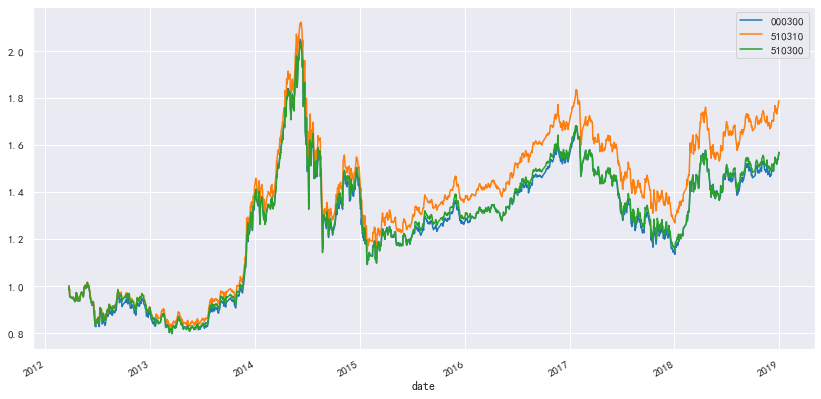

In [4]:
data_close=pd.DataFrame({'000300':data_000300.close,'510310':data_510310.close,'510300':data_510300.close}).dropna()
(data_close/data_close.iloc[0]).plot()
plt.legend()

In [5]:
data_close.pct_change().describe()

,000300,510310,510300
count,1650.0000,1650.0000,1650.0000
mean,0.0004,0.0005,0.0004
std,0.0148,0.0156,0.0158
min,-0.0875,-0.0997,-0.1001
25%,-0.0056,-0.0053,-0.0060
50%,0.0004,0.0000,0.0003
75%,0.0070,0.0066,0.0068
max,0.0671,0.1002,0.0999


In [6]:
data_close.iloc[-1]/data_close.iloc[0]

000300    1.5677
510310    1.7890
510300    1.5687
dtype: float64

In [31]:
data_510300['MA120']=QA.MA(data_510300['close'],120)
data_510310['MA120']=QA.MA(data_510310['close'],120)

<AxesSubplot:xlabel='date'>

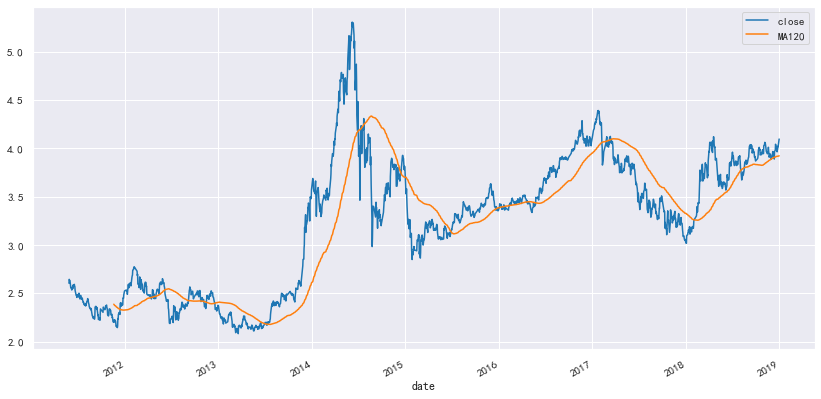

In [8]:
data_510300[['close','MA120']].plot()

In [9]:
class LocalDataAPI(abupy.MarketBu.ABuDataBase.StockBaseMarket,
                   abupy.MarketBu.ABuDataBase.SupportMixin):
    def _support_market(self):
        """声明数据源支持A股"""
        return [abupy.EMarketTargetType.E_MARKET_TARGET_CN]

    def kline(self, n_folds=2, start=None, end=None):
        ori_data = QA.QA_fetch_index_day_adv(self._symbol.symbol_code,
                                             start=start,
                                             end=end)
        df = ori_data.data
        df['pre_close'] = df['close'].shift()
        df['date'] = df.index.get_level_values(0)
        df['date'] = df['date'].dt.strftime('%Y%m%d').apply(
            lambda x: abupy.ABuDateUtil.date_str_to_int(x))
        df.index = df.index.droplevel(1)
        df.index.name = 'dt'
        df['date_week'] = df.index.dayofweek
        if start and end:
            return df[start:end]
        elif start:
            return df[start:]
        elif end:
            return df[:end]
        return df

    def minute(self, n_fold=5, *args, **kwargs):
        """分钟k线接口"""
        raise NotImplementedError('QAApi minute NotImplementedError!')

abupy.env.g_market_target = abupy.env.EMarketTargetType.E_MARKET_TARGET_CN
# 所有任务数据强制网络更新
abupy.env.g_data_fetch_mode = abupy.env.EMarketDataFetchMode.E_DATA_FETCH_FORCE_NET
# 使用QUATAXIS本地数据作为数据源
abupy.env.g_private_data_source = LocalDataAPI

from abupy.IndicatorBu.ABuNDAtr import calc_atr
from QUANTAXIS.QAIndicator.talib_series import SMA
import talib

class KLManager(abupy.AbuKLManager):
    def _fetch_pick_time_kl_pd(self, target_symbol):
        data = abupy.MarketBu.ABuSymbolPd.make_kl_df(
            target_symbol, start=self.benchmark.start, end=self.benchmark.end)
        if not data.empty:
            high = data['high']
            low = data['low']
            pre_close = data['pre_close']
            data['ma'] = SMA(data['close'], 20)
            data['ma120'] = SMA(data['close'], 120)
            data['ma60'] = SMA(data['close'], 60)
            data['atr14'] = calc_atr(high, low, pre_close, 14)
            data['atr21'] = calc_atr(high, low, pre_close, 21)
#             data['上涨市']=np.sign(data['close'].shift()-data['ma'].shift())
#             import pdb
#             pdb.set_trace()
            result = data[self.benchmark.start:self.benchmark.end]
            result.name = data.name
        else:
            return data
#         logging.info(result)
        return result

# 沪深300指数
benchmark = gquant.abupy.TradeBu.ABuBenchmark.AbuBenchmark(benchmark='000300',
                                                           start=START,
                                                           end=END)
# 资金管理。使用默认的手续费计算方法
capital = gquant.abupy.TradeBu.ABuCapital.AbuCapital(
    10000,
    benchmark,
)

def backtest(buy_factors,
             sell_factors,
             symbol,
             init_cash,
             **kwargs):
    start = kwargs.pop('start', START)
    end = kwargs.pop('end', END)

    benchmark = abupy.AbuBenchmark(symbol, start, end)
    capital = abupy.AbuCapital(init_cash, benchmark)
    klmanager = kwargs.pop('klmanager', KLManager)
    orders_pd, action_pd, _ = abupy.ABuPickTimeExecute.do_symbols_with_same_factors(
        [symbol],
        benchmark,
        buy_factors,
        sell_factors,
        capital,
        kl_pd_manager=klmanager(benchmark, capital),
        show=False)
    m = gquant.Metrics(orders_pd, action_pd, capital, benchmark)
    m.fit_metrics()
    if hasattr(m, 'act_sell') and not m.act_sell.empty:
        m.act_sell['profit_init'] = m.act_sell['profit'] / m.capital.read_cash
        m.act_sell['profit_init_hunder'] = m.act_sell['profit_init'] * 100
        return m
    return None

def get_report(m, name):
    p = m.profit_series(name='回测-{}'.format(name))
    p['平均获利期望'] = m.gains_mean  #平均获利期望\n",
    p['平均亏损期望'] = m.losses_mean  #平均亏损期望\n",
    p['盈亏比'] = m.win_loss_profit_rate  #盈亏比\n",
    p['策略年化收益'] = m.algorithm_annualized_returns  #策略年化收益\n",
    p['基准年化收益'] = m.benchmark_annualized_returns  #基准年化收益\n",
    c = m.order_has_ret
    p['赢利交易平均持股天数'] = c[c.profit > 0].keep_days.values.mean()  #赢利交易平均持股天数\n",
    p['亏损交易平均持股天数'] = c[c.profit <= 0].keep_days.values.mean()  #亏损交易平均持股天数\n",
    p = gquant.pd.to_numeric(p)
    return p.to_frame().round(2).T

In [10]:
class Position1(abupy.AbuPositionBase):
    """"""
    def _init_self(self, **kwargs):
        """子类仓位管理针对可扩展参数的初始化"""
        pass

    def fit_position(self, factor_object):
#         import pdb; 
#         pdb.set_trace()
#         print(factor_object.capital.capital_pd[['cash_blance','stocks_blance']].dropna().iloc[-1].sum())
#         print(factor_object.capital.capital_pd[['cash_blance','stocks_blance']].dropna().iloc[-1])
#         return 100
        #默认最大仓位为75%
        return self.read_cash * 0.85 / self.bp * self.deposit_rate

In [11]:
class BuyStrategy1(gquant.abupy.AbuFactorBuyTD, gquant.abupy.BuyCallMixin):
    def _init_self(self, **kwargs):
        self.col=kwargs.pop('col','ma120')
        self.factor_name = ""
        
    def fit_day(self, today):
        if today['close'] > today[self.col] and self.yesterday['close']<=self.yesterday[self.col]:
            return self.buy_tomorrow()
        return None

class SellStrategy1(gquant.abupy.AbuFactorSellBase):
    def _init_self(self, **kwargs):
        self.col=kwargs.pop('col','ma120')
        self.factor_name = ""

    def support_direction(self):
        return [abupy.ESupportDirection.DIRECTION_CAll.value]

    def fit_day(self, today, orders):
        if self.today_ind>0 and len(orders)>0:
            yesterday=self.kl_pd.iloc[self.today_ind - 1]
            if today['close'] < today[self.col] and yesterday['close']>=yesterday[self.col]:
                for order in orders:
                    self.sell_tomorrow(order)

In [12]:
bt1 = backtest([{'class': BuyStrategy1,'col':'ma60', 'position': {'class': Position1}}], [
               {'class': SellStrategy1,'col':'ma60'}], symbol='510300', init_cash=10000)
bt2 = backtest([{'class': BuyStrategy1,'col':'ma120', 'position': {'class': Position1}}], [
               {'class': SellStrategy1,'col':'ma120'}], symbol='510300', init_cash=10000)

bt3 = backtest([{'class': BuyStrategy1,'col':'ma60', 'position': {'class': Position1}}], [
               {'class': SellStrategy1,'col':'ma60'}], symbol='510310', init_cash=10000)
bt4 = backtest([{'class': BuyStrategy1,'col':'ma120', 'position': {'class': Position1}}], [
               {'class': SellStrategy1,'col':'ma120'}], symbol='510310', init_cash=10000)

Box(children=(Text(value='pid=12 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=12 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=12 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=12 begin work'), FloatProgress(value=0.0)))

In [13]:
# 非真实成交的度量，认为资金无限，无资金管理的情况下总体情况

pd.DataFrame({
    'name': ['510300','510300', '510310', '510310'],
    'MA': ['60','120', '60','120'],
    '买入后卖出的交易数量': [bt.order_has_ret.shape[0] for bt in [bt1,bt2,bt3,bt4]],
    '买入后尚未卖出的交易数量': [bt.order_keep.shape[0] for bt in [bt1,bt2,bt3,bt4]],
    '胜率': [bt.win_rate for bt in [bt1,bt2,bt3,bt4]],
    '平均获利期望': [bt.gains_mean for bt in [bt1,bt2,bt3,bt4]],
    '平均亏损期望': [bt.losses_mean for bt in [bt1,bt2,bt3,bt4]],
    '盈亏比': [bt.win_loss_profit_rate for bt in [bt1,bt2,bt3,bt4]],
    '所有交易收益比例和':[bt.order_has_ret.profit_cg.sum() for bt in [bt1,bt2,bt3,bt4]],
    '所有交易总盈亏和': [bt.all_profit for bt in [bt1,bt2,bt3,bt4]],
}).set_index('name')

,MA,买入后卖出的交易数量,买入后尚未卖出的交易数量,胜率,平均获利期望,平均亏损期望,盈亏比,所有交易收益比例和,所有交易总盈亏和
name,,,,,,,,,
510300,60,46,1,0.2391,0.1341,-0.0195,2.1797,0.7933,6711.35
510300,120,28,1,0.3929,0.1080,-0.0255,2.7480,0.7542,6309.55
510310,60,43,1,0.2558,0.1330,-0.0201,2.2839,0.8192,6962.95
510310,120,18,1,0.4444,0.1494,-0.0302,3.9725,0.8933,7571.25


In [14]:
# 考虑资金情况下的度量，进行与benchmark的收益度量对比，收益趋势，资金变动可视化，以及其它度量信息

pd.DataFrame({
    'name': ['510300','510300', '510310', '510310'],
    'MA': ['60','120', '60','120'],
    '策略收益':[bt.algorithm_period_returns for bt in [bt1,bt2,bt3,bt4]],
    '基准年化收益': [bt.benchmark_annualized_returns for bt in [bt1,bt2,bt3,bt4]],
    '策略年化收益': [bt.algorithm_annualized_returns for bt in [bt1,bt2,bt3,bt4]],
    '策略资金利用率比例': [bt.cash_utilization for bt in [bt1,bt2,bt3,bt4]],
    '最大回撤': [bt.max_drawdown for bt in [bt1,bt2,bt3,bt4]],
}).set_index('name')

,MA,策略收益,基准年化收益,策略年化收益,策略资金利用率比例,最大回撤
name,,,,,,
510300,60,0.6393,0.0794,0.0870,0.3725,-0.2453
510300,120,0.6201,0.0794,0.0844,0.3880,-0.3259
510310,60,0.6259,0.1213,0.0955,0.3732,-0.2491
510310,120,0.7583,0.1213,0.1157,0.3636,-0.3321


In [15]:
from abupy import abu, ABuProgress, AbuMetricsBase, EMarketTargetType, nd

In [45]:
# nd.ma.plot_ma_from_order(bt1.orders_pd,time_period=[60,120],date_ext=240)

In [46]:
# bt1.act_sell

In [47]:
# nd.ma.plot_ma_from_order(bt4.orders_pd,time_period=[60,120],date_ext=240)

In [42]:
bt4.plot_returns_cmp(only_info=True)

买入后卖出的交易数量:18
买入后尚未卖出的交易数量:1
胜率:44.4444%
平均获利期望:14.9393%
平均亏损期望:-3.0187%
盈亏比:3.9725
策略收益: 75.8274%
基准收益: 79.4892%
策略年化收益: 11.5739%
基准年化收益: 12.1328%
策略买入成交比例:100.0000%
策略资金利用率比例:36.3618%
策略共执行1651个交易日


In [44]:
bt2.plot_returns_cmp(only_info=True)

买入后卖出的交易数量:28
买入后尚未卖出的交易数量:1
胜率:39.2857%
平均获利期望:10.8018%
平均亏损期望:-2.5530%
盈亏比:2.7480
策略收益: 62.0144%
基准收益: 58.3337%
策略年化收益: 8.4382%
基准年化收益: 7.9374%
策略买入成交比例:100.0000%
策略资金利用率比例:38.8047%
策略共执行1852个交易日


In [51]:
bt4.act_sell

,Date,Price,Cnt,symbol,Direction,Date2,Price2,action,deal,sell_cost,buy_cost,sell_commission,buy_commission,profit,profit_cg,profit_cg_hunder,profit_init,profit_init_hunder
1,20131107,0.9330,9000.0,sh510310,1.0,20131029,0.9430,sell,True,8397.00,8487.00,7.5191,7.5191,-105.0382,-0.0124,-1.2376,-0.0105,-1.0504
3,20131220,0.9165,8800.0,sh510310,1.0,20131119,0.9620,sell,True,8065.20,8465.60,7.4196,7.4196,-415.2391,-0.0491,-4.9050,-0.0415,-4.1524
5,20140710,0.8630,9700.0,sh510310,1.0,20140703,0.8720,sell,True,8371.10,8458.40,7.5113,7.5113,-102.3227,-0.0121,-1.2097,-0.0102,-1.0232
7,20150703,1.5965,9700.0,sh510310,1.0,20140715,0.8755,sell,True,15486.05,8492.35,9.6458,9.6458,6974.4084,0.8213,82.1258,0.6974,69.7441
9,20150716,1.6015,4900.0,sh510310,1.0,20150714,1.7290,sell,True,7847.35,8472.10,7.3542,7.3542,-639.4584,-0.0755,-7.5478,-0.0639,-6.3946
11,20150727,1.6065,4900.0,sh510310,1.0,20150724,1.7150,sell,True,7871.85,8403.50,7.3616,7.3616,-546.3731,-0.0650,-6.5017,-0.0546,-5.4637
13,20160105,1.4220,5500.0,sh510310,1.0,20151218,1.5280,sell,True,7821.00,8404.00,7.3463,7.3463,-597.6926,-0.0711,-7.1120,-0.0598,-5.9769
15,20161229,1.3785,6500.0,sh510310,1.0,20160630,1.2895,sell,True,8960.25,8381.75,7.6881,7.6881,563.1238,0.0672,6.7185,0.0563,5.6312
17,20170113,1.3890,6100.0,sh510310,1.0,20170103,1.3870,sell,True,8472.90,8460.70,7.5419,7.5419,-2.8837,-0.0003,-0.0341,-0.0003,-0.0288
19,20170120,1.3930,6100.0,sh510310,1.0,20170119,1.3900,sell,True,8497.30,8479.00,7.5492,7.5492,3.2016,0.0004,0.0378,0.0003,0.0320


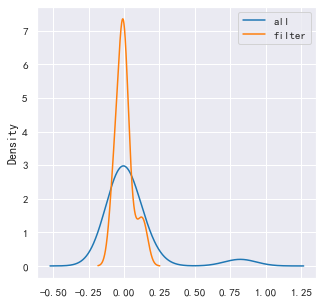

In [76]:
bt4.act_sell.profit_cg.plot(kind='kde',figsize=(5,5),label='all')
bt4.act_sell[bt4.act_sell.profit_cg<0.8].profit_cg.plot(kind='kde',figsize=(5,5),label='filter')
plt.legend()
plt.show()

In [263]:
data_510300.iloc[0].name,data_510300.iloc[-1].name

(Timestamp('2012-05-28 00:00:00'), Timestamp('2019-12-31 00:00:00'))

In [221]:
from tqdm import tqdm_notebook
import random
from QUANTAXIS.QAUtil.QADate import QA_util_datetime_to_strdate as dt2str


def generator():
    """随机选择迭代器"""
    while True:
        size = random.randint(500, data_510300.dropna().shape[0])
        start = random.randint(0, data_510300.dropna().shape[0] - size)
        end = start + size
        v = data_510300.dropna().iloc[start:end].reset_index()
        yield dt2str(v.iloc[0]['date'].date()), dt2str(
            v.iloc[-1]['date'].date())


g = generator()


def do_mc_test(times):
    test = []
    for i in tqdm_notebook(range(times)):
        s, e = next(g)
        #         logging.info('LEN:{}:{}~{}'.format(len(test),s,e))
        mc = backtest([{
            'class': BuyStrategy1,
            'col': 'ma120',
            'position': {
                'class': Position1
            }
        }], [{
            'class': SellStrategy1,
            'col': 'ma120'
        }],
            symbol='510310',
            start=s,
            end=e,
            init_cash=10000)
        if mc:
            mc.start=s
            mc.end=e
            test.append(mc)
    ts = []
    for m in test:
        t = m.profit_series()
        t['start'] = m.start
        t['end'] = m.end
        t['days'] = m.num_trading_days
        t['策略收益']=m.algorithm_period_returns 
        t['基准收益']=m.benchmark_period_returns 
        t['策略年化收益']=m.algorithm_annualized_returns 
        t['基准年化收益']=m.benchmark_annualized_returns 
        t['策略Sharpe夏普比率']=m.algorithm_sharpe
        t['基准Sharpe夏普比率']=m.benchmark_sharpe
        t['策略波动率Volatility']=m.algorithm_volatility
        t['基准波动率Volatility']=m.benchmark_volatility
        t['alpha阿尔法']=m.alpha
        t['beta贝塔']=m.beta
        t['Information信息比率']=m.information
        ts.append(t)
    result = gquant.pd.concat(ts, axis=1).T
    result['最终价值']=pd.to_numeric(result['最终价值'])
    result['days']=pd.to_numeric(result['days'])
    result['策略收益']=pd.to_numeric(result['策略收益'])
    result['基准收益']=pd.to_numeric(result['基准收益'])
    result['策略年化收益']=pd.to_numeric(result['策略年化收益'])
    result['基准年化收益']=pd.to_numeric(result['基准年化收益'])
    return result


def show_result(times, mcs):
    #     gquant.sns.distplot(mcs[mcs['交易次数']>=30]['R'])
    logging.info("测试{}次后交易次数>30的R乘数：\n{}".format(
        times, mcs[mcs['交易次数'] >= 30][['R', 'days']].describe()))

In [ ]:
mcs=do_mc_test(10000)

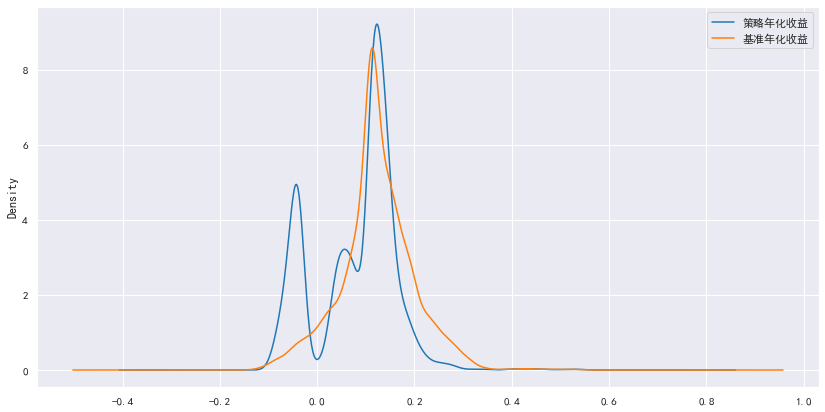

In [251]:
mcs['策略年化收益'].plot.kde()
mcs['基准年化收益'].plot.kde()
plt.legend()

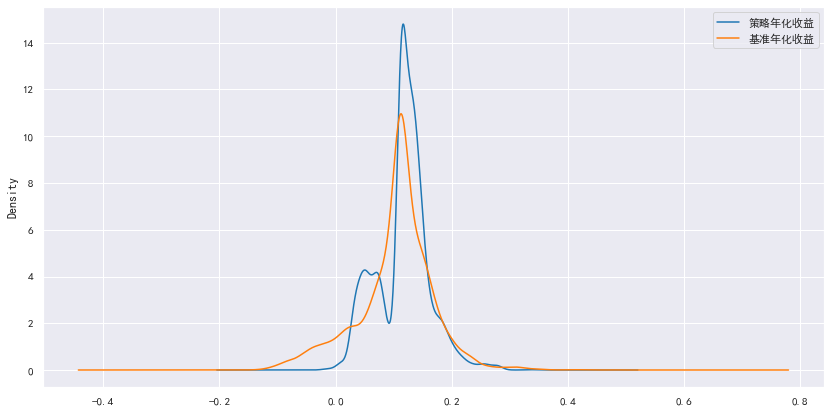

In [252]:
mcs[mcs['盈利次数']>0]['策略年化收益'].plot.kde()
mcs[mcs['盈利次数']>0]['基准年化收益'].plot.kde()
plt.legend()

In [266]:
mcs['策略年化收益']=pd.to_numeric(mcs['策略年化收益'])
mcs['基准年化收益']=pd.to_numeric(mcs['基准年化收益'])
mcs['亏损次数']=pd.to_numeric(mcs['亏损次数'])
mcs['盈利次数']=pd.to_numeric(mcs['盈利次数'])
mcs[['策略年化收益','基准年化收益']].describe()

,策略年化收益,基准年化收益
count,10000.0000,10000.0000
mean,0.0793,0.1229
std,0.0839,0.0762
min,-0.0901,-0.1372
25%,0.0305,0.0864
50%,0.1121,0.1181
75%,0.1340,0.1636
max,0.5431,0.5926


盈利次数>0的比率为75.48%

In [259]:
mcs[mcs['盈利次数']>0].shape[0]/mcs.shape[0]

0.7548

In [268]:
mcs[mcs['盈利次数']>0][['策略年化收益','基准年化收益']].describe()

,策略年化收益,基准年化收益
count,7548.0000,7548.0000
mean,0.1165,0.1038
std,0.0450,0.0653
min,-0.0232,-0.1372
25%,0.0883,0.0764
50%,0.1185,0.1109
75%,0.1400,0.1390
max,0.3394,0.4745


In [267]:
mcs[mcs['盈利次数']<=0]['亏损次数'].describe()

count    2452.0000
mean        2.9980
std         0.0606
min         1.0000
25%         3.0000
50%         3.0000
75%         3.0000
max         3.0000
Name: 亏损次数, dtype: float64

In [272]:
mcs[mcs['盈利次数']<=0][['策略年化收益','基准年化收益']].describe()

,策略年化收益,基准年化收益
count,2452.0000,2452.0000
mean,-0.0355,0.1818
std,0.0709,0.0771
min,-0.0901,-0.0311
25%,-0.0562,0.1391
50%,-0.0429,0.1833
75%,-0.0365,0.2304
max,0.5431,0.5926


In [270]:
mcs[mcs['盈利次数']>0][['盈利次数','亏损次数']].describe()

,盈利次数,亏损次数
count,7548.0000,7548.0000
mean,4.4012,7.6912
std,1.6844,2.7695
min,1.0000,0.0000
25%,4.0000,5.0000
50%,5.0000,9.0000
75%,5.0000,11.0000
max,7.0000,11.0000
